In [1]:
library(DWLS)
library(pbmcapply)
library(fastSave)
library(COSG)
library(stringr)
library(dplyr)
library(Seurat)


scdata_test<-readRDS.lbzip2('~/scRNA_Seq_data/PBMC/Stephenson_seurat.rdsFS',n.cores = 200)
EXP_combine <- readRDS("~/ReCIDE/应用_前二/SLE/bulk_data/GSE50772_exprs.rds")

cell_names=intersect(row.names(scdata_test),row.names(EXP_combine))
scdata_test=scdata_test[cell_names,]

scdata_test@meta.data[["usetype"]]<-scdata_test@meta.data[["true"]]###########
cell.table<-as.data.frame(table(scdata_test@meta.data[["usetype"]]))
cell.table<-cell.table[cell.table[,2]>3,]
scdata_test<-subset(scdata_test,usetype %in% cell.table[,1])
gc()
labels<-as.character(scdata_test@meta.data[["usetype"]])
# labels <- str_replace(labels, "&", "_")
# labels <- str_replace(labels, "-", "_")
labels <- str_replace(labels, "-", "_")
labels <- str_replace(labels, "\\.", "_")
# labels <- str_replace(labels, " ", "_")

scdata_test@meta.data[['usetype']]<-labels
Idents(scdata_test)<-'usetype'

scdata_test<-NormalizeData(scdata_test)
# scdata_test<-NormalizeData(scdata_test)

COSG_markers <- cosg(
  scdata_test,
  groups='all',
  assay='RNA',
  slot='data',
  mu=1,
  n_genes_user=100)

##整理marker基因名字等
de_group_list<-list()
for (i in 1:ncol(COSG_markers[["names"]])) {
  de_group_list[[i]]<-as.data.frame(COSG_markers[["names"]][,i])
  de_group_list[[i]][,2]<-as.data.frame(COSG_markers[["scores"]][,i])
  colnames(de_group_list[[i]])<-c('gene_name','scores')
  row.names(de_group_list[[i]])<-de_group_list[[i]][,1]
}
names(de_group_list)<-colnames(COSG_markers[["names"]])

##fold-change筛选
df2<-as.data.frame(t(as.data.frame(scdata_test@assays[["RNA"]]@data)))
gc()
df2[,"usetype"]<-scdata_test@meta.data[["usetype"]]
ref_list1<-group_by(df2,usetype) %>% summarize_each(mean)
ref_list1<-as.data.frame(ref_list1)
row.names(ref_list1)<-ref_list1[,1]
ref_list1<-ref_list1[,-1]
ref_list1<-as.data.frame(t(ref_list1))

secondFC <- c()
for(gene in rownames(ref_list1)){
  secondFC <- c(secondFC, sort(as.numeric(ref_list1[gene, ]), decreasing = T)[1]/sort(as.numeric(ref_list1[gene, ]), decreasing = T)[2])
}
names(secondFC) <- row.names(ref_list1)
secondFC<-secondFC[secondFC>1.5]
secondFC<-secondFC[!(is.na(secondFC))]

de_group_listFB<-de_group_list
for (i in 1:length(de_group_list)) {
  de_group_list[[i]]<-subset(de_group_list[[i]],row.names(de_group_list[[i]]) %in% names(secondFC))
}

#吃低保
low_gene=10+round(length(de_group_listFB)/10)
for (i in 1:length(de_group_list)) {
  if(nrow(de_group_list[[i]])<10){
    de_group_list[[i]]<-de_group_listFB[[i]][1:low_gene,]
  }}



id<-labels
scdata<-as.matrix(scdata_test@assays[["RNA"]]@counts)
colnames(scdata) <- str_replace(colnames(scdata), "-", "_")


numberofGenes <- c()
for (i in unique(id)) {
  de_group <- de_group_list[[i]]
  # de_group <- readRDS(file = paste(path, "/de_", i, ".rds",
  #                                  sep = ""))
  # DEGenes <- rownames(de_group)[intersect(which(de_group$scores < pval.cutoff), which(de_group$avg_log2FC > diff.cutoff))]
  DEGenes <- rownames(de_group)
  
  nonMir = grep("MIR|Mir", DEGenes, invert = T)
  assign(paste("cluster_lrTest.table.", i, sep = ""), de_group[which(rownames(de_group) %in% DEGenes[nonMir]), ])
  numberofGenes <- c(numberofGenes, length(DEGenes[nonMir]))
}

f=100
Sig_list_in<-list()
conditionNumbers <- c()
for (G in 50:f) {
  Genes <- c()
  j = 1
  for (i in unique(id)) {
    if (numberofGenes[j] > 0) {
      temp <- paste("cluster_lrTest.table.", i, sep = "")
      temp <- as.name(temp)
      temp <- eval(parse(text = temp))
      temp <- temp[order(temp$scores, decreasing = TRUE),
      ]
      Genes <- c(Genes, (rownames(temp)[1:min(G, numberofGenes[j])]))
    }
    j = j + 1
  }
  Genes <- unique(Genes)
  ExprSubset <- scdata[Genes, ]
  Sig <- NULL
  # for (i in unique(id)) {
  #   Sig <- cbind(Sig, (apply(ExprSubset, 1, function(y) mean(y[which(id ==  i)]))))
  # }
  # 
  
  Sig<-as.data.frame(t(ExprSubset))
  Sig[,'id']<-id
  Sig=group_by(Sig,id) %>% summarize_each(mean)
  Sig<-as.data.frame(t(Sig))
  colnames(Sig)<-Sig[1,]
  Sig<-Sig[-1,]
  # Sig <- as.data.frame(lapply(Sig, as.numeric))
  Sig <- dplyr::mutate_all(Sig, as.numeric)
  
  # Sig2<-cbind(Sig,e1[row.names(Sig),])
  # kappa(Sig2)
  colnames(Sig) <- unique(id)
  conditionNumbers <- c(conditionNumbers, kappa(Sig))##降低kappa值，kappa值越高说明多重共线性越强，我们希望kappa值低一些
  Sig_list_in[[G-49]]<-Sig
}


# ##################
# plot(conditionNumbers)
# 
# ##每个细胞类型至少有10个marker，尝试让kappa值最小
# 
# # kappa<100则认为有共线性程度很小。
# # 100<=kappa<=1000则认为存在中等程度或者较强的共线性。
# # 若kappa>1000则认为存在很严重的共线性
G <-  which.min(conditionNumbers) + min(49, numberofGenes - 1)
#
#
Genes <- c()
j = 1
for (i in unique(id)) {
  if (numberofGenes[j] > 0) {
    temp <- paste("cluster_lrTest.table.", i, sep = "")
    temp <- as.name(temp)
    temp <- eval(parse(text = temp))
    temp <- temp[order(temp$scores, decreasing = TRUE),
    ]
    Genes <- c(Genes, (rownames(temp)[1:min(G, numberofGenes[j])]))
  }
  j = j + 1
}
Genes <- unique(Genes)
ExprSubset <- scdata[Genes, ]
# Sig <- NULL
# for (i in unique(id)) {
#   Sig <- cbind(Sig, (apply(ExprSubset, 1, function(y) mean(y[which(id == i)]))))
# }
# colnames(Sig) <- unique(id)
Sig<-as.data.frame(t(ExprSubset))
Sig[,'id']<-id
Sig=group_by(Sig,id) %>% summarize_each(mean)
Sig<-as.data.frame(t(Sig))
colnames(Sig)<-Sig[1,]
Sig<-Sig[-1,]
# Sig <- as.data.frame(lapply(Sig, as.numeric))
Sig <- dplyr::mutate_all(Sig, as.numeric)


saveRDS(Sig,file = '~/ReCIDE/应用_前二/SLE_true_new/DWLS_build/PBMC_com_sig.rds')
# save(Sig_list,file = '~/SWORD/前聚类测试/CRC_Sig_list09.RData')




The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Loading required package: parallel


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7604363,406.2,11760101,628.1,10933382,584.0
Vcells,376888730,2875.5,919952429,7018.7,898279532,6853.4


Warning message:
“x or y has vectors with all zero; consider setting use_nan = TRUE to set these values to NaN or use_nan = FALSE to suppress this warning”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 10.5 GiB”


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7650941,408.7,11760101,628.1,11760101,628.1
Vcells,1788317718,13643.8,5534679334,42226.3,5534670190,42226.2


Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 10.5 GiB”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead.”
Warning message:
“`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `acro

In [2]:


EXP<- readRDS("~/ReCIDE/应用_前二/SLE_99/bulk_data/GSE50772_exprs.rds")

Sig_list<- readRDS("~/ReCIDE/应用_前二/SLE_true_new/DWLS_build/PBMC_com_sig.rds")

###########################
com_ref_DWLS=Sig_list


sep_solDWLS<-list()
fun_DWLS_in<-function(i){
  bulk<-as.numeric(EXP[,i])
  # bulk=apply(bulk,2,sum)
  names(bulk)=row.names(EXP)
  
  
  ref1=as.matrix(com_ref_DWLS)
  
  tr<-trimData(ref1,bulk)
  output<-try(solveDampenedWLS(tr$sig,tr$bulk), TRUE)
  
  return(output)
}


sep_solDWLS<-pbmclapply(1:length(EXP),fun_DWLS_in,mc.cores = 110)
names(sep_solDWLS)<-names(EXP)
# }
#save(sep_solDWLS)
# sep_solDWLS[[156]]<-NULL
saveRDS(sep_solDWLS,file='~/ReCIDE/应用_前二/SLE_true_new/DWLS_build/DWLS_com_output.rds')
# save(sep_solDWLS.list,file='~/SWORD/前聚类测试/sep_solDWLS_09ref.RData')

prd<-sep_solDWLS

prd[[1]]<-as.data.frame(prd[[1]])
df_merge<-prd[[1]]
colnames(df_merge)[1]<-names(prd)[1]

for(j in 2:length(prd)){
  
  prd[[j]]<-as.data.frame(prd[[j]])
  df_merge<-merge(df_merge, prd[[j]], by = "row.names", all = TRUE)
  row.names(df_merge)<-df_merge[,1]
  df_merge<-df_merge[,-1]
  colnames(df_merge)[j]<-names(prd)[j]
}

prd_com<-df_merge[,sort(names(df_merge))]

# prd_after['Mono_prolif',]=0
prd_com=prd_com[sort(row.names(prd_com)),sort(colnames(prd_com))]

saveRDS(prd_com,file='~/ReCIDE/应用_前二/SLE_true_new/DWLS_build/prd_com_PBMC.rds')



Warning message in readRDS("~/SWORD/应用/SLE/bulk_data/GSE50772_meta.rds"):
“input string 'Samples were hybridized to GeneChip® Human Genome U133 Plus 2.0 Arrays (Affymetrix, Inc.).  Arrays were washed and stained in the Affymetrix Fluidics station and scanned on a GeneChip® scanner 3000' cannot be translated from 'ANSI_X3.4-1968' to UTF-8, but is valid UTF-8”
Warning message in readRDS("~/SWORD/应用/SLE/bulk_data/GSE50772_meta.rds"):
“input string 'Samples were hybridized to GeneChip® Human Genome U133 Plus 2.0 Arrays (Affymetrix, Inc.).  Arrays were washed and stained in the Affymetrix Fluidics station and scanned on a GeneChip® scanner 3000' cannot be translated from 'ANSI_X3.4-1968' to UTF-8, but is valid UTF-8”
Warning message in readRDS("~/SWORD/应用/SLE/bulk_data/GSE50772_meta.rds"):
“input string 'Samples were hybridized to GeneChip® Human Genome U133 Plus 2.0 Arrays (Affymetrix, Inc.).  Arrays were washed and stained in the Affymetrix Fluidics station and scanned on a GeneChip® scan

[1] TRUE

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


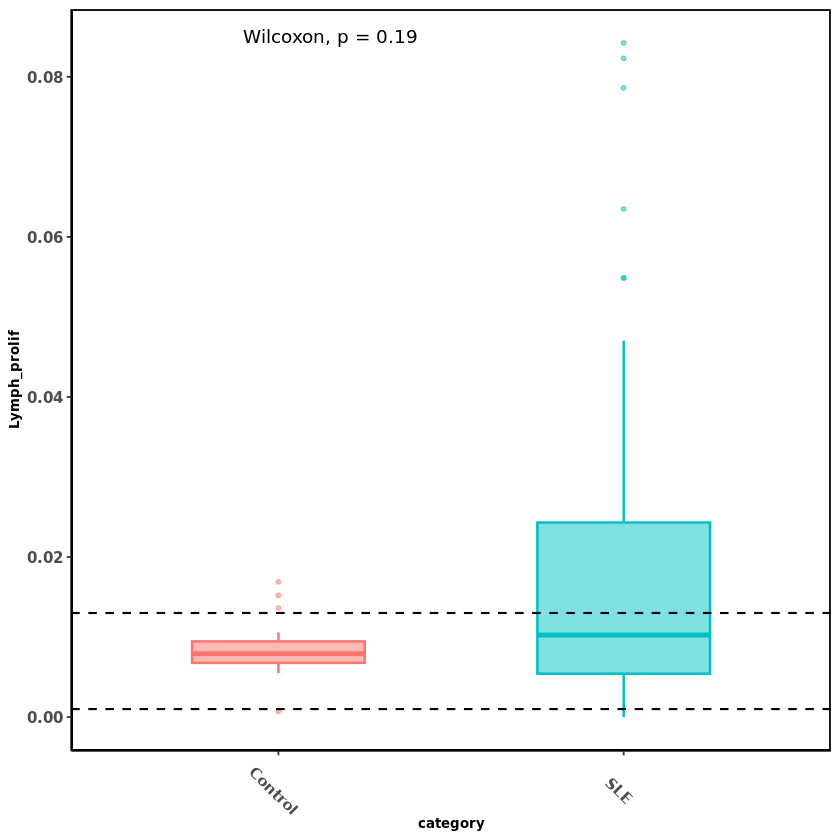

In [3]:
library(ggplot2)
library(ggpubr)

prd_df <- readRDS("~/ReCIDE/应用_前二/SLE_true_new/DWLS_build/prd_com_PBMC.rds")
prd_df=prd_df[,sort(colnames(prd_df))]

metadata<- readRDS("~/SWORD/应用/SLE/bulk_data/GSE50772_meta.rds")
metadata=metadata[sort(row.names(metadata)),]
# [1] "B_exhausted"           "B_immature"           
# [3] "B_naive"               "B_non_switched_memory"
# [5] "B_switched_memory"     "CD14_mono"            
# [7] "CD16_mono"             "CD4_CM"               
# [9] "CD4_EM"                "CD4_IL22"             
# [11] "CD4_Naive"             "CD4_Th"               
# [13] "CD8_EM"                "CD8_Naive"            
# [15] "CD8_TE"                "DC"                   
# [17] "HSC"                   "ILC"                  
# [19] "Lymph_prolif"          "MAIT"                 
# [21] "NK"                    "NKT"                  
# [23] "Plasma"                "Platelets"            
# [25] "RBC"                   "Treg"                 
# [27] "gdT"                   "pDC"                  
# [29] "category"             

all(row.names(metadata)==colnames(prd_df))

plot_data=as.data.frame(t(prd_df))

plot_data[,'category']=metadata[,'disease.status.ch1']

ggplot(plot_data, aes(x= category, y=Lymph_prolif,fill=category)) + 
  geom_boxplot(aes(color = category),#这里的fill如果不设就是空心的
               size = .7, alpha = .5, outlier.size = 1,
               position = position_dodge(width = 0.5), width = 0.5) +
  # position_dodge是箱子间距离  width是箱宽
  # geom_boxplot(data=subset(plot_data, methods %in% 'empty'), width = .5) +
  theme_classic() +
  theme(
    axis.text.x = element_text(size = 9, face = "bold", angle = -45),
    axis.text.y = element_text(size = 9, face = "bold"),
    # axis.text.x = element_blank(),
    # axis.text.y = element_blank(),
    axis.title = element_text(size = 8, face = "bold"),
    plot.title = element_text(size = 8, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 10, face = "bold", hjust = 0.5),
    panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),
    legend.position = 'none'
    # axis.title = element_text(size = 8)
  )+
  stat_compare_means()+
  geom_hline(yintercept = 0.001,col = 'Black',linewidth=0.6,linetype=2)+
  geom_hline(yintercept = 0.013,col = 'Black',linewidth=0.6,linetype=2)

